# *Carga de librerías y configuración inicial*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
from scipy.stats import ks_2samp
from pathlib import Path
from geopandas import GeoDataFrame
import geopandas as gpd
from geopandas.tools import sjoin

ModuleNotFoundError: No module named 'geopandas'

In [4]:
INPUT_PATH = Path("accidentes.csv")
OUTPUT_PATH = Path("datos_procesados.parquet")

In [5]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

# *Cargar datos y eliminación de columnas innecesarias*

In [6]:
df = pd.read_csv("accidentes.csv", low_memory=False, parse_dates=["Start_Time", "End_Time", "Weather_Timestamp"])

In [7]:
cols_to_drop = [
    "Wind_Chill(F)", "Description", "Source", "Street", 
    "City", "Zipcode", "Country", "Airport_Code", "ID","End_Lng","End_Lat",'Precipitation(in)', "Temperature(F)", "Wind_Speed(mph)", "Visibility(mi)"
]

In [8]:
df["Temperature(C)"] = (df["Temperature(F)"] - 32) * 5/9
df["Wind_Speed(km/h)"] = df["Wind_Speed(mph)"] * 1.60934 
df["Visibility(km)"] = df["Visibility(mi)"] * 1.60934

In [9]:
if "End_Lat" in df.columns and "End_Lng" in df.columns:
    df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

# *Análisis exploratorio de datos general del dataset*

In [10]:
print("\n *Resumen Estadístico de Variables Numéricas:*")
print(df.describe())


 *Resumen Estadístico de Variables Numéricas:*
           Severity     Start_Lat     Start_Lng  Distance(mi)  \
count  7.728394e+06  7.728394e+06  7.728394e+06  7.728394e+06   
mean   2.212384e+00  3.620119e+01 -9.470255e+01  5.618423e-01   
min    1.000000e+00  2.455480e+01 -1.246238e+02  0.000000e+00   
25%    2.000000e+00  3.339963e+01 -1.172194e+02  0.000000e+00   
50%    2.000000e+00  3.582397e+01 -8.776662e+01  3.000000e-02   
75%    2.000000e+00  4.008496e+01 -8.035368e+01  4.640000e-01   
max    4.000000e+00  4.900220e+01 -6.711317e+01  4.417500e+02   
std    4.875313e-01  5.076079e+00  1.739176e+01  1.776811e+00   

                   Weather_Timestamp   Humidity(%)  Pressure(in)  \
count                        7608166  7.554250e+06  7.587715e+06   
mean   2020-06-02 10:06:41.888674560  6.483104e+01  2.953899e+01   
min              2016-01-14 19:51:00  1.000000e+00  0.000000e+00   
25%              2018-11-20 18:35:00  4.800000e+01  2.937000e+01   
50%              2020-11-1

In [11]:
print("\n *Resumen de Variables Categóricas:*")
print(df.describe(include="object"))


 *Resumen de Variables Categóricas:*
                 Start_Time             End_Time       County    State  \
count               7728394              7728394      7728394  7728394   
unique              6131796              6705355         1871       49   
top     2021-01-26 16:16:13  2021-11-22 08:00:00  Los Angeles       CA   
freq                    225                  112       526851  1741433   

          Timezone Wind_Direction Weather_Condition Sunrise_Sunset  \
count      7720586        7553188           7554935        7705148   
unique           4             24               144              2   
top     US/Eastern           CALM              Fair            Day   
freq       3580167         961624           2560802        5334553   

       Civil_Twilight Nautical_Twilight Astronomical_Twilight  
count         7705148           7705148               7705148  
unique              2                 2                     2  
top               Day               Day         

## *Tratamiento de valores faltantes*

### Visualización de porcentaje de valores faltantes en variables

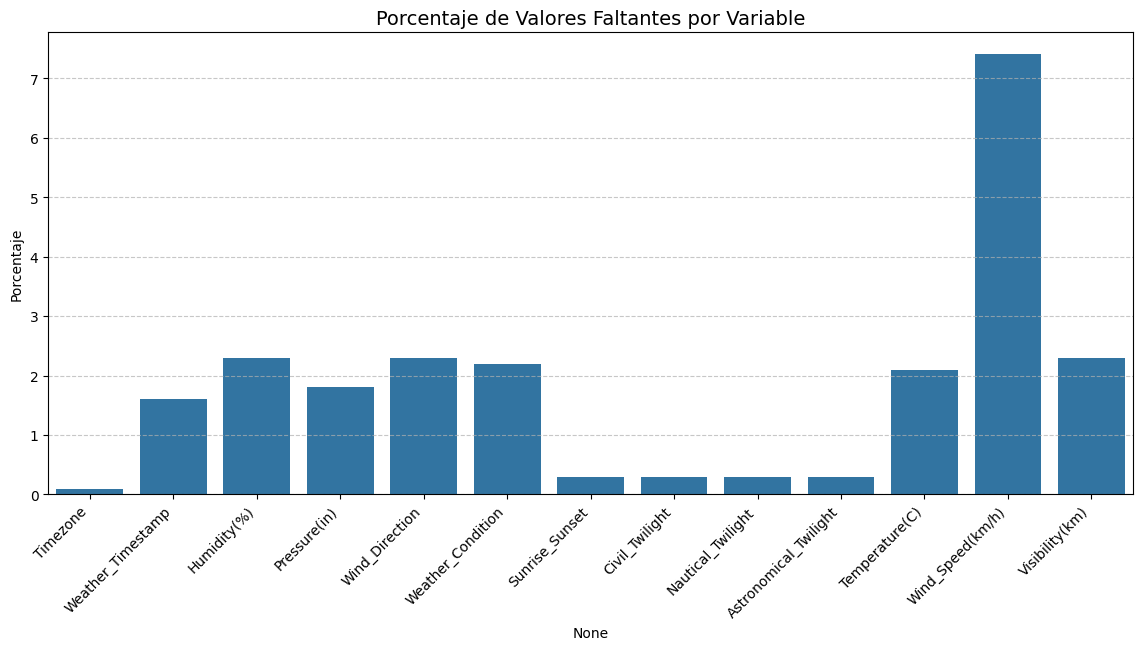

In [12]:
missing_values = (df.isna().mean() * 100).round(1)
missing_values = missing_values[missing_values > 0]
plt.figure(figsize=(14, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, color="#1f77b4")
plt.title("Porcentaje de Valores Faltantes por Variable", fontsize=14)
plt.ylabel("Porcentaje")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Cantidad de valores faltantes 

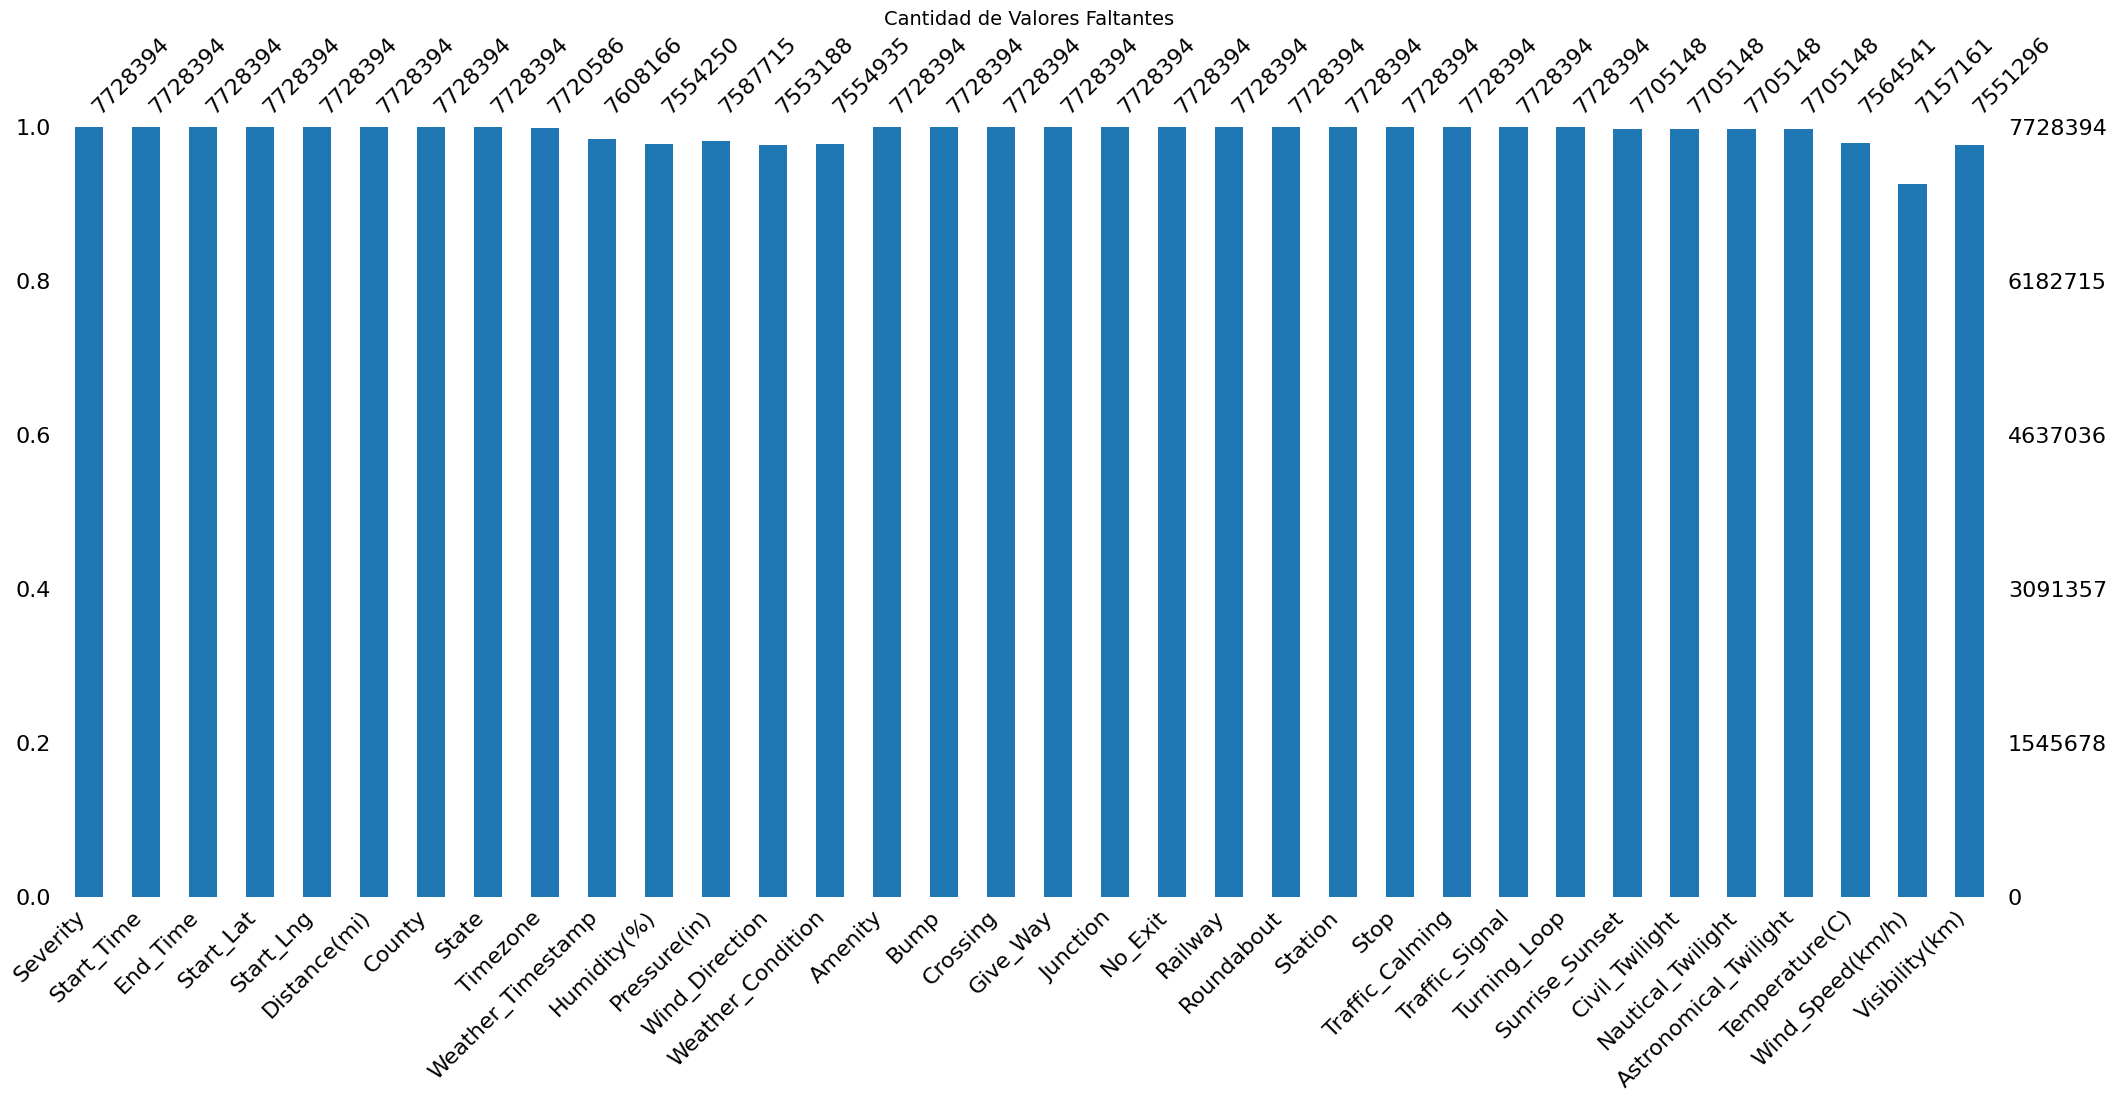

In [14]:
plt.figure(figsize=(12, 5))
msno.bar(df, color="#1f77b4")
plt.title("Cantidad de Valores Faltantes", fontsize=14)
plt.show()

### Imputación de valores faltantes

In [ ]:
variables = {
    'Timezone': 'categorical',
    'Weather_Timestamp': 'datetime',
    'Temperature(C)': 'numeric',
    'Humidity(%)': 'numeric',
    'Pressure(in)': 'numeric',
    'Visibility(km)': 'numeric',
    'Wind_Direction': 'categorical',
    'Wind_Speed(km/h)': 'numeric',
    'Weather_Condition': 'categorical',
    'Sunrise_Sunset': 'categorical',
    'Civil_Twilight': 'categorical',
    'Nautical_Twilight': 'categorical',
    'Astronomical_Twilight': 'categorical'
}

# Crear una copia del DataFrame original
df_original = df.copy()

In [ ]:
# Eliminar filas con valores faltantes en 'Weather_Condition'
df.dropna(subset=['Weather_Condition'], inplace=True)

In [ ]:
# Imputación de variables numéricas con la mediana del estado
for col, col_type in variables.items():
    if col_type == 'numeric':
        df[col] = df.groupby("State")[col].transform(lambda x: x.fillna(x.median()))

In [ ]:

# Imputación de variables categóricas con muestreo basado en frecuencias
for col, col_type in variables.items():
    if col_type == 'categorical':
        probs = df[col].value_counts(normalize=True) 
        df[col] = df[col].apply(lambda x: np.random.choice(probs.index, p=probs.values) if pd.isna(x) else x)

### Análisis de la imputación de los datos 

In [ ]:
# Prueba de Kolmogorov-Smirnov para evaluar la distribución tras la imputación
ks_results = {}
alpha = 0.05  

In [20]:
for col, col_type in variables.items():
    if col_type == 'numeric' and df[col].isna().sum() == 0:  
        original_values = df_original[col].dropna()
        imputed_values = df[col]

        stat, p_value = ks_2samp(original_values, imputed_values)

        ks_results[col] = {
            'KS_Statistic': stat,
            'P_Value': p_value,
            'Same_Distribution': p_value > alpha  
        }
freq_results = {}

In [21]:
for col, col_type in variables.items():
    if col_type == 'categorical' and col in df.columns:
        original_freq = df_original[col].value_counts(normalize=True)
        imputed_freq = df[col].value_counts(normalize=True)
        freq_results[col] = {
            'Original_Frequencies': original_freq,
            'Imputed_Frequencies': imputed_freq
        }

In [22]:
for col, result in ks_results.items():
    print(f"Variable: {col}")
    print(f"  KS Statistic: {result['KS_Statistic']:.4f}")
    print(f"  P-Value: {result['P_Value']:.4f}")
    print(f"  ¿Mantiene la distribución? {'Sí' if result['Same_Distribution'] else 'No'}\n")

Variable: Temperature(C)
  KS Statistic: 0.0012
  P-Value: 0.0000
  ¿Mantiene la distribución? No

Variable: Humidity(%)
  KS Statistic: 0.0020
  P-Value: 0.0000
  ¿Mantiene la distribución? No

Variable: Pressure(in)
  KS Statistic: 0.0010
  P-Value: 0.0011
  ¿Mantiene la distribución? No

Variable: Visibility(km)
  KS Statistic: 0.0004
  P-Value: 0.5630
  ¿Mantiene la distribución? Sí

Variable: Wind_Speed(km/h)
  KS Statistic: 0.0207
  P-Value: 0.0000
  ¿Mantiene la distribución? No



In [23]:
for col, result in freq_results.items():
    print(f"Variable: {col}")
    print("  Frecuencias Originales:")
    print(result['Original_Frequencies'])
    print("  Frecuencias Imputadas:")
    print(result['Imputed_Frequencies'])
    print()

Variable: Timezone
  Frecuencias Originales:
Timezone
US/Eastern     0.463717
US/Pacific     0.267206
US/Central     0.213147
US/Mountain    0.055931
Name: proportion, dtype: float64
  Frecuencias Imputadas:
Timezone
US/Eastern     0.462903
US/Pacific     0.267552
US/Central     0.214789
US/Mountain    0.054756
Name: proportion, dtype: float64

Variable: Wind_Direction
  Frecuencias Originales:
Wind_Direction
CALM        0.127314
S           0.055604
SSW         0.050951
W           0.050828
WNW         0.050148
NW          0.048900
Calm        0.048795
SW          0.048254
WSW         0.046842
SSE         0.046220
NNW         0.044144
N           0.040665
SE          0.039043
E           0.036927
ESE         0.035523
NE          0.034242
ENE         0.034221
NNE         0.033802
VAR         0.033174
South       0.023483
West        0.021812
North       0.020307
Variable    0.015092
East        0.013709
Name: proportion, dtype: float64
  Frecuencias Imputadas:
Wind_Direction
CALM      

# *Limpieza y categorización de variables*

In [24]:
def categorize_weather(condition):
    categories = {
        "Lluvia ligera": ["Light Rain", "Light Rain Showers", "Light Rain Shower", "Light Rain / Windy"],
        "Lluvia moderada": ["Rain", "Rain Shower", "Rain Showers", "Rain Shower / Windy"],
        "Lluvia intensa": ["Heavy Rain", "Heavy Rain Showers", "Heavy Rain Shower", "Heavy Rain Shower / Windy", "Heavy Rain / Windy"],
        "Llovizna ligera": ["Light Drizzle", "Light Drizzle / Windy"],
        "Llovizna moderada": ["Drizzle", "Drizzle / Windy"],
        "Llovizna intensa": ["Heavy Drizzle"],
        "Nieve ligera": ["Light Snow", "Light Snow Showers", "Light Snow Shower", "Light Snow / Windy"],
        "Nieve moderada": ["Snow", "Snow Showers", "Snow / Windy"],
        "Nieve intensa": ["Heavy Snow", "Heavy Snow Showers", "Heavy Snow / Windy"],
        "Aguanieve ligera": ["Light Sleet", "Light Snow and Sleet", "Light Snow and Sleet / Windy"],
        "Aguanieve moderada": ["Sleet", "Snow and Sleet", "Snow and Sleet / Windy"],
        "Aguanieve intensa": ["Heavy Sleet", "Heavy Sleet / Windy"],
        "Granizo ligero": ["Light Hail", "Small Hail"],
        "Granizo moderado": ["Hail"],
        "Cielo despejado": ["Clear", "Fair"],
        "Nublado": ["Cloudy", "Mostly Cloudy", "Scattered Clouds", "Overcast", "Partly Cloudy"],
        "Tormenta eléctrica": ["Thunderstorm", "Thunder", "T-Storm", "Thunder in the Vicinity", "Thunder / Windy", "Thunder / Wintry Mix", "Light Thunderstorm"],
        "Tormentas fuertes": ["Heavy T-Storm", "Heavy Thunderstorms and Rain", "Heavy Thunderstorms and Snow", "Heavy T-Storm / Windy"],
        "Tormenta con granizo": ["Thunder and Hail", "Thunder and Hail / Windy", "Heavy Thunderstorms with Small Hail"],
        "Lluvia helada ligera": ["Light Freezing Rain", "Light Freezing Rain / Windy"],
        "Lluvia helada moderada": ["Freezing Rain", "Freezing Rain / Windy"],
        "Lluvia helada intensa": ["Heavy Freezing Rain", "Heavy Freezing Rain / Windy"],
        "Llovizna helada ligera": ["Light Freezing Drizzle"],
        "Llovizna helada moderada": ["Freezing Drizzle"],
        "Llovizna helada intensa": ["Heavy Freezing Drizzle"],
        "Niebla ligera": ["Mist", "Light Fog", "Partial Fog", "Shallow Fog", "Light Haze"],
        "Niebla densa": ["Fog", "Fog / Windy", "Patches of Fog", "Patches of Fog / Windy", "Shallow Fog / Windy", "Light Freezing Fog"],
        "Humo y neblina": ["Haze", "Smoke", "Heavy Smoke", "Haze / Windy", "Smoke / Windy"],
        "Viento fuerte": ["Blowing Dust / Windy", "Cloudy / Windy", "Fair / Windy", "Mostly Cloudy / Windy", "Partly Cloudy / Windy", "Windy", "Blowing Sand", "Widespread Dust", "Blowing Dust", "Blowing Snow Nearby", "Blowing Snow", "Sand / Windy", "Sand / Dust Whirlwinds", "Sand / Dust Whirls Nearby", "Sand / Dust Whirlwinds / Windy", "Duststorm", "Drifting Snow / Windy"],
        "Mezcla invernal": ["Wintry Mix", "Wintry Mix / Windy", "Snow and Thunder", "Snow and Thunder / Windy", "Light Snow with Thunder", "Rain and Sleet"],
        "Tornado": ["Tornado", "Funnel Cloud"],
        "Otros": ["Volcanic Ash", "Showers in the Vicinity", "Light Rain with Thunder", "Low Drifting Snow", "Light Ice Pellets", "Squalls", "N/A Precipitation", "Sand", "Snow Grains", "Heavy Ice Pellets", "Drizzle and Fog", "Light Snow Grains", "Heavy Blowing Snow", "Light Blowing Snow", "Dust Whirls", "Sleet and Thunder", "Heavy Sleet and Thunder", "Heavy Sleet / Windy"]
    }
    for category, values in categories.items():
        if condition in values:
            return category
    return "Desconocido"

In [25]:
def assign_weather_categories(df, column_name="Weather_Condition"):
    df[column_name] = df[column_name].apply(categorize_weather)
    return df

In [26]:
def clean_temperature(temp):
    if temp < -62.2:
        return np.random.uniform(-62.2, -61.9)  
    elif temp > 56.7:
        return np.random.uniform(56.5, 56.7)  
    return temp  

In [27]:
def clean_pressure(pres):
    if pres < 25 or pres > 32:
        return None  
    elif pres < 25.69:
        return np.random.uniform(25.69, 25.9)  
    elif pres > 31.42:
        return np.random.uniform(31.2, 31.42)  

In [28]:
def clean_visibility(vis):
    return np.clip(vis, 0, 10) 

In [ ]:
# Corrección de valores atípicos en temperatura, presión y visibilidad
df["Temperature(C)"] = df["Temperature(C)"].apply(clean_temperature)
df["Pressure(in)"] = df["Pressure(in)"].apply(clean_pressure)
df["Visibility(km)"] = df["Visibility(km)"].apply(lambda x: np.clip(x, 0, 16.09)) 

In [30]:
df = assign_weather_categories(df, "Weather_Condition")

In [ ]:
# Eliminación de filas con valores nulos en 'Pressure(in)'
df = df.dropna(subset=["Pressure(in)"])

In [32]:
geometry = gpd.points_from_xy(df["Start_Lng"], df["Start_Lat"])
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

In [ ]:
# Cargar archivo GeoJSON con los estados de EE.UU.
states = gpd.read_file("https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json")
states = states.to_crs("EPSG:4326")
gdf = gpd.sjoin(gdf, states[['geometry', 'name']], how='left', predicate='within')
gdf.drop(columns=['index_right'], inplace=True, errors='ignore')
gdf["Start_Time"] = pd.to_datetime(gdf["Start_Time"], errors="coerce")

In [ ]:
# Guardar el dataset procesado
if not OUTPUT_PATH.exists():
    
    gdf.to_parquet(OUTPUT_PATH, index=False)
    print(f"\nDataset procesado guardado en: {OUTPUT_PATH}")
else:
    print("\n¡El archivo procesado ya existe! Elimínalo para regenerarlo.")


¡El archivo procesado ya existe! Elimínalo para regenerarlo.
